In [3]:
%pip install --upgrade jax[cuda12]

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 15.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 25.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 18.3 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 552.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
%pip install jaxopt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.7 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import numpy as onp
import jax.numpy as jnp
from jax.numpy import trapezoid
from jax import grad, jit, vmap, value_and_grad, hessian
from jax.numpy.fft import fft, fftfreq, fftshift, ifft
from jax import random, config, jit
from jax.nn import sigmoid
from jaxopt import LBFGS, BFGS, ArmijoSGD
from jax.lax import Precision, stop_gradient
from jax.flatten_util import ravel_pytree
from collections import namedtuple
import math

config.update("jax_enable_x64", True)

In [111]:
num = onp.random.randint(low=0, high=10000)
seed = random.key(num)
print(num)

9939


In [112]:
def pre_alpha_R(x):
    #return x**2/(0.8*(xb)**2) - 0.5
    #return -0.5+x**2/xb**2/2
    #return -0.8*jnp.cos(x/(0.1*xb))
    return jnp.ones_like(x)*(0.9)

def pre_R_func_0(x):
    m=0
    func = (2*xb - jnp.sqrt((x+xb)**2 + (x-xb)**2 - 2*(x+xb)*(xb-x)*pre_alpha_R(x)))*((x+xb)**2 + (x-xb)**2)**(m/2)/(1+pre_alpha_R(x))

    #dfunc_dx = -2*x/jnp.sqrt((x+xb)**2 + (x-xb)**2)

    return func.squeeze() #, dfunc_dx

In [113]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-1):
    w_key, b_key = random.split(key)
    #return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return scale * random.uniform(w_key, (n, m), minval = - 1/jnp.sqrt(n*m), maxval =  1/jnp.sqrt(n*m)), scale * random.uniform(b_key, (n,), minval = - 1/jnp.sqrt(n), maxval =  1/jnp.sqrt(n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    p = [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys[:-1])]
    # p.append(random.uniform(keys[-1], (), minval = - 1, maxval =  1))
    # p.append(1e-1*random.normal(keys[-1], ()))
    return p

In [114]:
layer_sizes = [1, 10, 10, 10, 5, 5, 5, 5, 1]
#layer_sizes = [1, 64, 1]

step_size = 0.001
r_func_norm = 1.0

num_epochs = 1001
batch_size = 2000
params_1 = init_network_params(layer_sizes, seed)
params_2 = init_network_params(layer_sizes, seed)

L = 8.

# points_half = jnp.geomspace(1, L+1, batch_size//2 + 1) - 1
# points = jnp.concatenate((-points_half[1:][::-1], points_half))
# points = jnp.expand_dims(points, axis = 1)

points = jnp.expand_dims(jnp.linspace(-L,L, num = batch_size+1), axis = 1)
# p_a = jnp.array([[-L]])
# p_b = jnp.array([[L]])
# points = random.uniform(seed, (batch_size-1, 1), minval = -L, maxval = L)

# points = jnp.vstack((p_a, points, p_b))

n_factor = L
points = points/n_factor

# points_s = jnp.sort(points, axis=0)

xb = L/n_factor

sol_true = 2*jnp.atan(jnp.exp(points*n_factor))
d_sol_true_dx = 2*jnp.exp(points*n_factor)/(1+jnp.exp(2*points*n_factor))
sol_true_norm = jnp.sqrt(jnp.trapezoid((jnp.squeeze(sol_true))**2, x = points*n_factor, axis = 0)/(2*xb))
print(sol_true_norm.squeeze())

t0 = jnp.squeeze(sol_true)[0]
t1 = jnp.squeeze(sol_true)[-1]

dt0 = jnp.squeeze(d_sol_true_dx)[0]
dt1 = jnp.squeeze(d_sol_true_dx)[-1]

5.939135122498355


In [115]:
jnp.all(ravel_pytree(params_1)[0] == ravel_pytree(params_2)[0])

Array(True, dtype=bool)

In [116]:
n_factor

8.0

In [117]:
ravel_pytree(params_1)[0].shape

(391,)

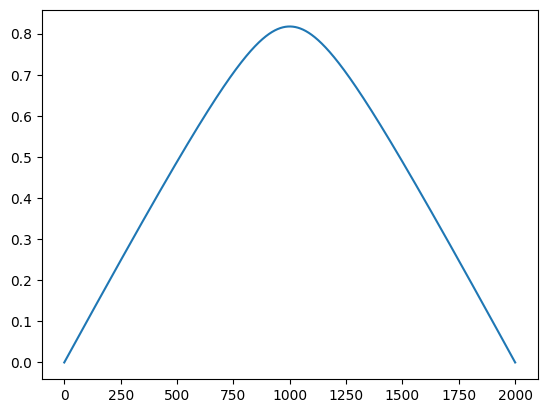

In [118]:
import matplotlib.pyplot as plt

pre_r_func = pre_R_func_0(points)
plt.plot(pre_r_func)
# r_func_norm = stop_gradient(jnp.max(pre_r_func))
# print(r_func_norm)

In [119]:
def tanh(x):
    return 1*jnp.tanh(x)

def alpha_R(x):
    #return x**2/(0.8*(xb)**2) - 0.5
    #return -0.5+x**2/xb**2/2
    #return -0.8*jnp.cos(x/(0.1*xb))
    return jnp.ones_like(x)*(0.9)

def R_func_0(x):
    m=0
    func = (2*xb - jnp.sqrt((x+xb)**2 + (x-xb)**2 - 2*(x+xb)*(xb-x)*alpha_R(x)))*((x+xb)**2 + (x-xb)**2)**(m/2)/(1+alpha_R(x))

    #dfunc_dx = -2*x/jnp.sqrt((x+xb)**2 + (x-xb)**2)

    return func.squeeze() #, dfunc_dx

R_func_val_grad = value_and_grad(R_func_0)

def R_func(x):
    func, dfunc_dx = R_func_val_grad(x)
    #max_fun = stop_gradient(2*jnp.max(func))

    return func/r_func_norm, dfunc_dx/r_func_norm

v_R_func = vmap(R_func)

def boundary_func(x):
    func1 = (t1-t0)/(2*xb)*x + (t0+t1)/2
    dfunc1_dx = jnp.ones_like(x)*(t1-t0)/(2*xb)
    
    func2 = -(dt0+dt1)/(2*xb)*x + (dt0 - dt1)/2

    # func = jnp.pi*sigmoid(x*n_factor)
    # dfunc_dx = n_factor*jnp.pi*sigmoid(x*n_factor)*(1-sigmoid(x*n_factor))

    return func1, dfunc1_dx, func2

def forward(params, x):
    # per-example predictions
    r_func, dr_func_dx = R_func(x)
    b_func, db_func_dx, n_func = boundary_func(x)
    activations = x

    # for w, b in params:

    #   outputs = jnp.dot(w, activations) + b
    #   activations = tanh(outputs)

    ############################################################################
    w0, b0 = params[0]

    outputs = jnp.dot(w0, activations) + b0
    activations_in = tanh(outputs)

    w1, b1 = params[1]

    outputs = jnp.dot(w1, activations_in) + b1
    activations = tanh(outputs)

    w2, b2 = params[2]

    outputs = jnp.dot(w2, activations) + b2

    outputs = outputs + activations_in
    activations_out = tanh(outputs)

    w3, b3 = params[3]

    outputs = jnp.dot(w3, activations_out) + b3

    activations = tanh(outputs)

    w4, b4 = params[4]

    outputs = jnp.dot(w4, activations) + b4

    activations_in = tanh(outputs)

    w5, b5 = params[5]

    outputs = jnp.dot(w5, activations) + b5

    activations = tanh(outputs)

    w6, b6 = params[6]

    outputs = jnp.dot(w6, activations) + b6
    outputs = outputs + activations_in

    activations_out = tanh(outputs)

    w7, b7 = params[7]

    outputs = jnp.dot(w7, activations_out) + b7

    activations = tanh(outputs)
    ############################################################################
    
    # r_scale = params[-1]

    res = b_func + r_func*n_func - r_func*dr_func_dx*db_func_dx + r_func**2*activations
    #res = b_func + (1+r_scale)*r_func**2*activations
    return jnp.squeeze(res)

def forward_f(params, x):
    return jnp.squeeze(forward(params, x))

deep_ritz = value_and_grad(forward, argnums=1)
v_deep_ritz = vmap(deep_ritz, in_axes = (None, 0))

def pinn_forward(params, x):

    d2u_dx2 = hessian(forward, argnums=1)(params, x)

    u = forward(params, x)

    return u, d2u_dx2

v_pinn = vmap(pinn_forward, in_axes = (None, 0))

v_out_value = vmap(forward, in_axes = (None, 0))

In [120]:
initial_out_1, initial_dout_dx_1 = v_deep_ritz(params_1, points)
print(initial_out_1.shape)
print(initial_dout_dx_1.shape)

(2001,)
(2001, 1)


In [121]:
initial_dout_dx_1[0]-dt0

Array([-2.45788633e-16], dtype=float64)

In [122]:
initial_out_2, initial_d2out_dx2_2 = v_pinn(params_2, points)
print(initial_out_2.shape)
print(initial_d2out_dx2_2.shape)

(2001,)
(2001, 1, 1)


In [123]:
res = v_out_value(params_1, points)

In [124]:
res.shape

(2001,)

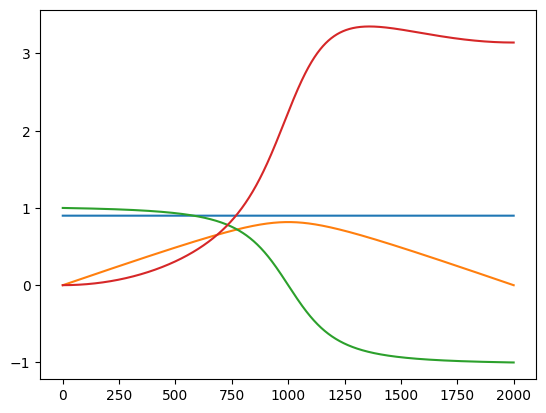

In [125]:
import matplotlib.pyplot as plt

alpha_func = alpha_R(points)
r_func, dr_func_dx = v_R_func(points)
b_func, db_func_dx, n_func = boundary_func(points)

plt.plot(alpha_func)
plt.plot(r_func)
plt.plot(dr_func_dx)
plt.plot(b_func.squeeze() + 
         r_func.squeeze()*n_func.squeeze() - 
         r_func.squeeze()*dr_func_dx.squeeze()*db_func_dx.squeeze() + 
         r_func.squeeze()**2)

In [126]:
jnp.min(r_func)

Array(0., dtype=float64)

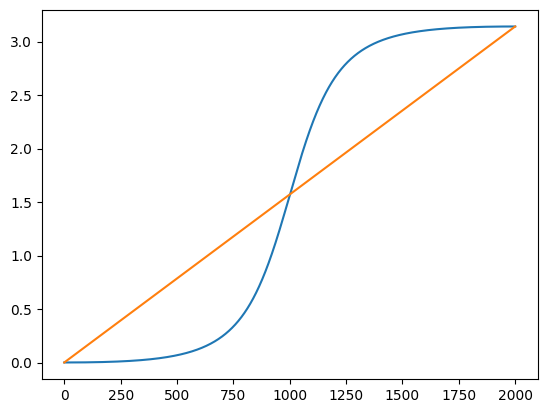

In [127]:
import matplotlib.pyplot as plt
plt.plot(initial_out_2)
plt.plot(b_func)

In [128]:
@jit
def loss_deep_ritz(params, points):
  out, dout_dx = v_deep_ritz(params, points)

  return jnp.trapezoid(dout_dx.squeeze()**2/n_factor**2 + jnp.sin(out.squeeze())**2, x = points, axis = 0).squeeze()

@jit
def loss_pinn(params, points):
  u, d2u_dx2 = v_pinn(params, points)

  return jnp.sum((d2u_dx2.squeeze()/n_factor**2 - jnp.sin(u.squeeze())*jnp.cos(u.squeeze()))**2, axis = 0).squeeze()/(batch_size+1)

@jit
def l2_accuracy(sol, sol_true, points):
    res = jnp.sqrt(jnp.trapezoid((jnp.squeeze(sol) - jnp.squeeze(sol_true))**2, x = points*n_factor, axis = 0)/(2*L))
    return jnp.squeeze(res)

@jit
def conv_accuracy(sol, sol_true):
    sol_spec = fft(jnp.squeeze(sol))
    sol_true_spec = fft(jnp.squeeze(sol_true))

    spec_mul = sol_spec*sol_true_spec

    conv = ifft(spec_mul)
    return jnp.argmax(jnp.real(conv))
@jit
def shift_l2_error(sol, sol_true, points):
    y = (sol.squeeze()-jnp.pi/2)**2
    sol_center = jnp.argmin(y)
    
    y = (sol_true.squeeze()-jnp.pi/2)**2
    true_center = jnp.argmin(y)
    
    delta = (points*n_factor)[sol_center] - (points*n_factor)[true_center]
    
    true_shifted = (2*jnp.atan(jnp.exp(points*n_factor-delta.squeeze()))).squeeze()
    
    return l2_accuracy(sol, true_shifted, points)

@jit
def zero_position(sol):
    y = (sol.squeeze()-jnp.pi/2)**2
    return jnp.argmin(y)

In [129]:
loss_deep_ritz(params_1, points)

Array(0.50382924, dtype=float64)

In [130]:
loss_pinn(params_2, points)

Array(0.00203623, dtype=float64)

In [131]:
import time

# optimizer = BFGS(
#     loss,
#     stepsize = 0.003,
#     linesearch="zoom",
#     verbose = False,
#     max_stepsize=1.0,
#     linesearch_init = "max",
#     maxls = 50,
#     tol=1e-6,
#     jit = True)

#optimizer = ArmijoSGD(loss, max_stepsize=0.1, momentum=0.9)

#optimizer = LBFGS(loss, stepsize = 0.006, history_size = 200)

optimizer_1 = LBFGS(loss_deep_ritz, linesearch = "hager-zhang", max_stepsize=0.05, 
                    linesearch_init='max', history_size = 100, verbose=False)
optimizer_2 = LBFGS(loss_pinn, linesearch = "hager-zhang", max_stepsize=0.05, 
                    linesearch_init='max', history_size = 100, verbose=False)
#"hager-zhang"

state_1 = optimizer_1.init_state(params_1, points)
state_2 = optimizer_2.init_state(params_2, points)

loss_array_1 = jnp.empty(num_epochs)
loss_array_2 = jnp.empty(num_epochs)

acc_array_1 = jnp.empty(num_epochs)
acc_array_2 = jnp.empty(num_epochs)

s_error_array_1 = jnp.empty(num_epochs)
s_error_array_2 = jnp.empty(num_epochs)

step_array_1 = jnp.empty(num_epochs)
step_array_2 = jnp.empty(num_epochs)

zero_pos_1 = jnp.empty(num_epochs)
zero_pos_2 = jnp.empty(num_epochs)

# sol_true = 2*jnp.atan(jnp.exp(points*n_factor))
# sol_spec = jnp.abs(fftshift(fft(jnp.squeeze(sol_true))))

acc_check_1 = 100
acc_check_2 = 100

for epoch in range(num_epochs):
  start_time = time.time()

  loss_train_1 = loss_deep_ritz(params_1, points)
  loss_train_2 = loss_pinn(params_2, points)

  params_1, state_1 = optimizer_1.update(params_1, state_1, points)
  params_2, state_2 = optimizer_2.update(params_2, state_2, points)

  out_1 = v_out_value(params_1, points)
  out_2 = v_out_value(params_2, points)

  # out_1_spec = jnp.abs(fftshift(fft(jnp.squeeze(out_1))))
  # out_2_spec = jnp.abs(fftshift(fft(jnp.squeeze(out_2))))

  zero_pos_current_1 = zero_position(out_1)
  zero_pos_current_2 = zero_position(out_2)

  zero_pos_1 = zero_pos_1.at[epoch].set(zero_pos_current_1)
  zero_pos_2 = zero_pos_2.at[epoch].set(zero_pos_current_2)

  loss_array_1 = loss_array_1.at[epoch].set(loss_train_1)
  loss_array_2 = loss_array_2.at[epoch].set(loss_train_2)

  acc_current_1 = l2_accuracy(out_1, sol_true, points)
  acc_current_2 = l2_accuracy(out_2, sol_true, points)

  s_error_current_1 = shift_l2_error(out_1, sol_true, points)
  s_error_current_2 = shift_l2_error(out_2, sol_true, points)

  if acc_current_1 < acc_check_1:
      best_p_1 = params_1
      acc_check_1 = acc_current_1

  if acc_current_2 < acc_check_2:
      best_p_2 = params_2
      acc_check_2 = acc_current_2

  acc_array_1 = acc_array_1.at[epoch].set(acc_current_1)
  acc_array_2 = acc_array_2.at[epoch].set(acc_current_2)

  s_error_array_1 = s_error_array_1.at[epoch].set(s_error_current_1)
  s_error_array_2 = s_error_array_2.at[epoch].set(s_error_current_2)

  step_array_1 = step_array_1.at[epoch].set(state_1.stepsize)
  step_array_2 = step_array_2.at[epoch].set(state_2.stepsize)

  epoch_time = time.time() - start_time

  if (epoch)%10 == 0:
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set Deep Ritz loss {}".format(loss_train_1))
    print("Deep acc", acc_current_1)
    print("Training set PINN loss {}".format(loss_train_2))
    print("PINN acc", acc_current_2, "\n")

Epoch 0 in 90.19 sec
Training set Deep Ritz loss 0.5038292443567813
Deep acc 0.042206114350032145
Training set PINN loss 0.0020362322301139602
PINN acc 0.042233558174535925 

Epoch 10 in 0.38 sec
Training set Deep Ritz loss 0.5001570670173876
Deep acc 0.02181767312236051
Training set PINN loss 0.002009955931280824
PINN acc 0.049285848216206594 

Epoch 20 in 0.27 sec
Training set Deep Ritz loss 0.5000127555877238
Deep acc 0.009349395703400331
Training set PINN loss 5.8182525932072123e-05
PINN acc 0.008004952458931321 

Epoch 30 in 0.25 sec
Training set Deep Ritz loss 0.5000083348528972
Deep acc 0.007347722194440246
Training set PINN loss 1.8151233622275282e-05
PINN acc 0.007274656589900258 

Epoch 40 in 0.25 sec
Training set Deep Ritz loss 0.5000064440400509
Deep acc 0.0009969690791440684
Training set PINN loss 1.498600219158564e-05
PINN acc 0.00522026115576343 

Epoch 50 in 0.25 sec
Training set Deep Ritz loss 0.5000059127199994
Deep acc 0.0011060225475729077
Training set PINN loss 1.1

In [132]:
out_1, d_out_dx_1 = v_deep_ritz(params_1, points)
out_2, d2_out_dx2_2 = v_pinn(params_2, points)

best_out_1 = v_out_value(best_p_1, points)
best_out_2 = v_out_value(best_p_2, points)

print(out_1.shape)

(2001,)


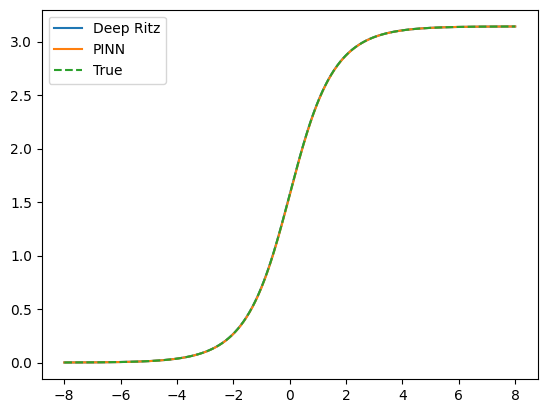

In [133]:
import matplotlib.pyplot as plt
plt.plot(points*n_factor, out_1, label = "Deep Ritz")
plt.plot(points*n_factor, out_2, label = "PINN")
plt.plot(points*n_factor, 2*jnp.atan(jnp.exp(points*n_factor)), "--", label = "True")
plt.legend()
plt.show()

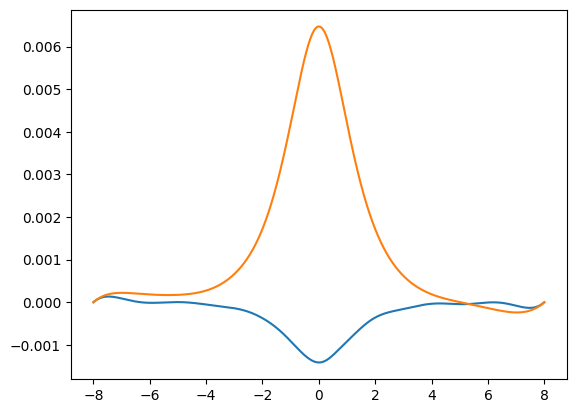

In [134]:
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(out_1))
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(out_2))

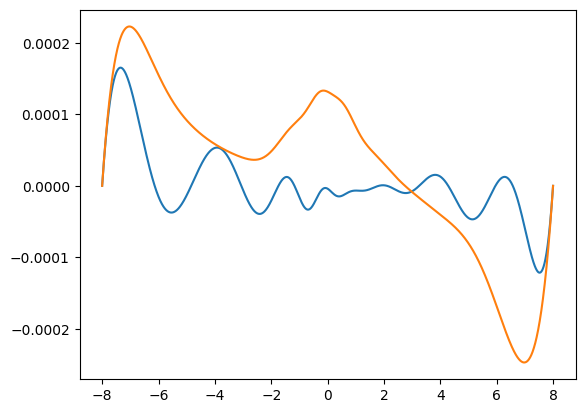

In [135]:
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(best_out_1))
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(best_out_2))

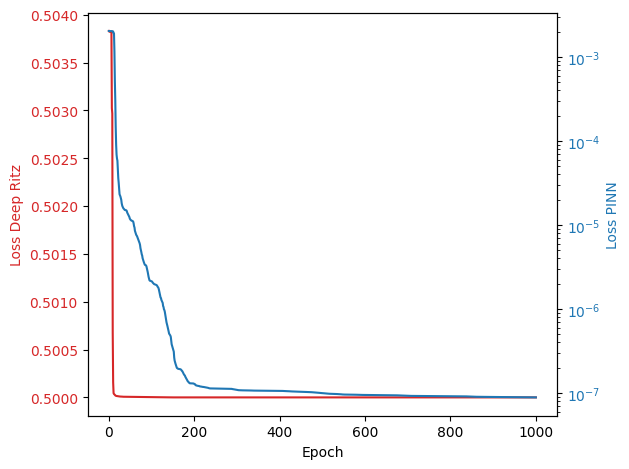

In [136]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Deep Ritz', color=color)
ax1.plot(loss_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss PINN', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(loss_array_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

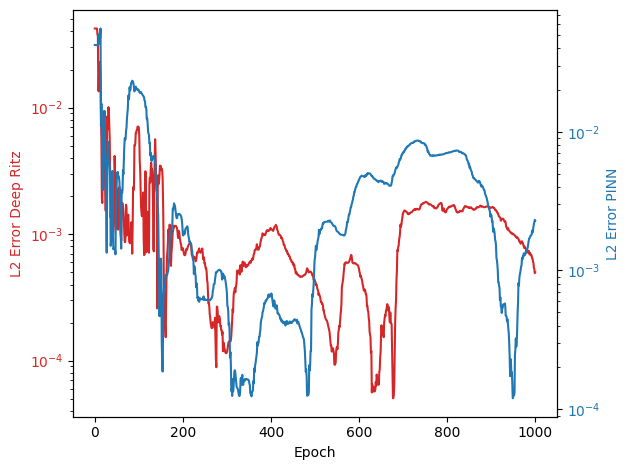

In [137]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Error Deep Ritz', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('L2 Error PINN', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(acc_array_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

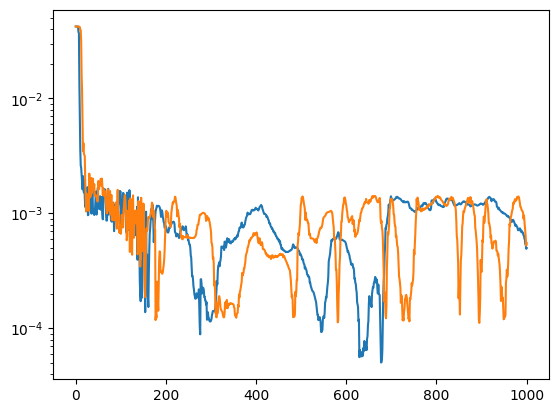

In [138]:
plt.plot(s_error_array_1)
plt.plot(s_error_array_2)
plt.yscale('log')
plt.show()

In [139]:
print("min acc Deep Ritz", jnp.min(acc_array_1))
print("min acc PINN", jnp.min(acc_array_2))

min acc Deep Ritz 5.050405892387809e-05
min acc PINN 0.0001199338276974054


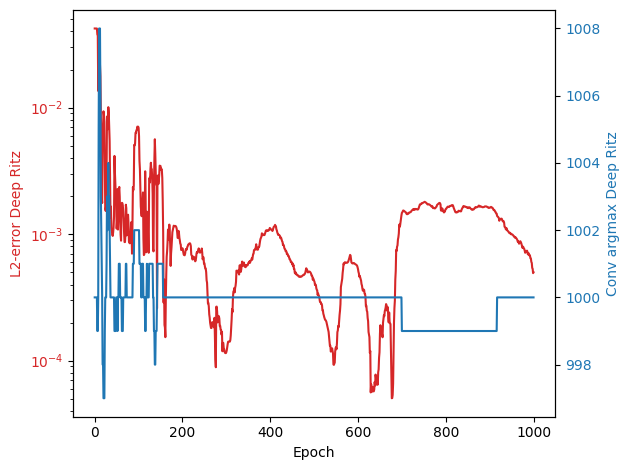

In [140]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2-error Deep Ritz', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Conv argmax Deep Ritz', color=color)  # we already handled the x-label with ax1
ax2.plot(zero_pos_1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

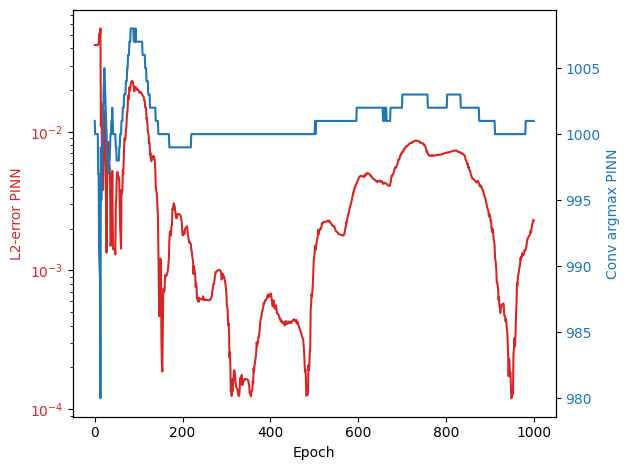

In [141]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2-error PINN', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Conv argmax PINN', color=color)  # we already handled the x-label with ax1
ax2.plot(zero_pos_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

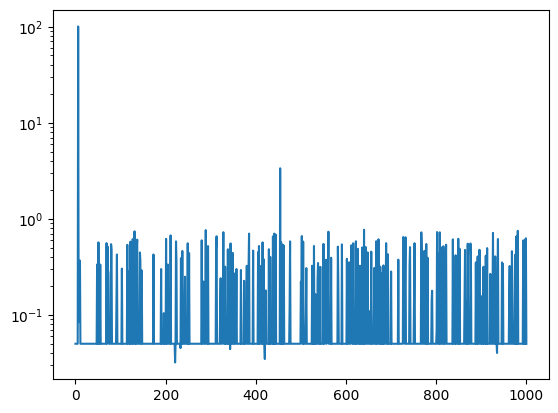

In [142]:
plt.plot(step_array_1)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [143]:
jnp.mean(step_array_1)

Array(0.22494508, dtype=float64)

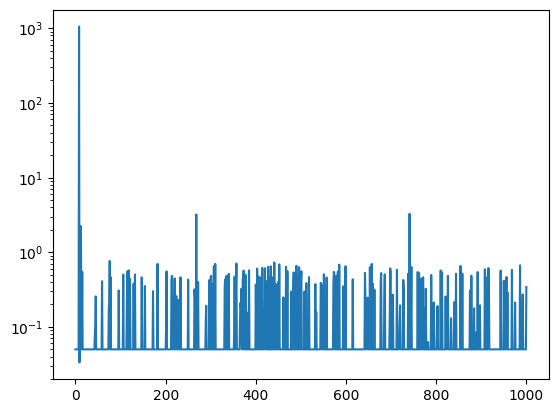

In [144]:
plt.plot(step_array_2)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [145]:
jnp.mean(step_array_2)

Array(1.17592259, dtype=float64)

In [146]:
np_initial_out_1 = onp.asarray(initial_out_1)
np_initial_dout_dx_1 = onp.asarray(initial_dout_dx_1)

np_initial_out_2 = onp.asarray(initial_out_2)
np_initial_d2out_dx2_2= onp.asarray(initial_d2out_dx2_2)

np_initial_out_total = onp.vstack((np_initial_out_1.squeeze(), 
                                   np_initial_dout_dx_1.squeeze(), 
                                   np_initial_out_2.squeeze(), 
                                   np_initial_d2out_dx2_2.squeeze()))
print(np_initial_out_total.shape)

onp.savetxt("initial_out_total.txt", np_initial_out_total.T, header='dp_out, dp_first_der, pinn_out, pinn_second_der', delimiter=",")

(4, 2001)


In [147]:
np_alpha_func = onp.asarray(alpha_func)

np_r_func = onp.asarray(r_func)
np_dr_func_dx = onp.asarray(dr_func_dx)

np_b_func = onp.asarray(b_func)
np_db_func_dx = onp.asarray(db_func_dx)
np_n_func = onp.asarray(n_func)

np_R_func_total = onp.vstack((np_alpha_func.squeeze(),
                             np_r_func.squeeze(), 
                             np_dr_func_dx.squeeze(),
                             np_b_func.squeeze(),
                             np_db_func_dx.squeeze(),
                             np_n_func.squeeze()))
print(np_R_func_total.shape)

onp.savetxt("R_func_total.txt", np_R_func_total.T, 
            header='alpha_func, r_func, r_func_der, b_func, b_func_der, n_func', delimiter=",")

(6, 2001)


In [148]:
np_out_1 = onp.asarray(out_1)
np_d_out_dx_1 = onp.asarray(d_out_dx_1)

np_out_2 = onp.asarray(out_2)
np_d2_out_dx2_2 = onp.asarray(d2_out_dx2_2)

np_out_total = onp.vstack((np_out_1.squeeze(), np_d_out_dx_1.squeeze(), np_out_2.squeeze(), np_d2_out_dx2_2.squeeze()))
print(np_out_total.shape)

onp.savetxt("out_total.txt", np_out_total.T, header='dp_out, dp_first_der, pinn_out, pinn_second_der', delimiter=",")

(4, 2001)


In [149]:
# out_1, d_out_dx_1 = v_deep_ritz(params_1, points)
# out_2, d2_out_dx2_2 = v_pinn(params_2, points)

In [150]:
onp.savetxt("points.txt", onp.asarray(points.squeeze()), delimiter=",")

In [151]:
np_loss_array_1 = onp.asarray(loss_array_1)
np_loss_array_2 = onp.asarray(loss_array_2)
np_loss_array = onp.vstack((np_loss_array_1, np_loss_array_2))
print(np_loss_array.T.shape)
onp.savetxt("loss.txt", np_loss_array.T, header='loss_dp, loss_pinn', delimiter=",")

(1001, 2)


In [152]:
np_acc_array_1 = onp.asarray(acc_array_1)
np_acc_array_2 = onp.asarray(acc_array_2)
np_acc_array = onp.vstack((np_acc_array_1, np_acc_array_2))
print(np_acc_array.T.shape)
onp.savetxt("error.txt", np_acc_array.T, header='error_dp, error_pinn', delimiter=",")

(1001, 2)


In [153]:
np_s_error_array_1 = onp.asarray(s_error_array_1)
np_s_error_array_2 = onp.asarray(s_error_array_2)
np_s_error_array = onp.vstack((np_s_error_array_1, np_s_error_array_2))
print(np_s_error_array.T.shape)
onp.savetxt("s_error.txt", np_s_error_array.T, header='s_error_dp, s_error_pinn', delimiter=",")

(1001, 2)


In [154]:
np_step_array_1 = onp.asarray(step_array_1)
np_step_array_2 = onp.asarray(step_array_2)
np_step_array = onp.vstack((np_step_array_1, np_step_array_2))
print(np_step_array.T.shape)
onp.savetxt("step.txt", np_step_array.T, header='step_dp, step_pinn', delimiter=",")

(1001, 2)


In [155]:
np_zero_pos_1 = onp.asarray(zero_pos_1)
np_zero_pos_2 = onp.asarray(zero_pos_2)
np_zero_pos = onp.vstack((np_zero_pos_1, np_zero_pos_2))
print(np_step_array.T.shape)
onp.savetxt("zero_pos.txt", np_zero_pos.T, header='zero_pos_dp, zero_pos_pinn', delimiter=",")

(1001, 2)
